# Big Data in Finance: Part IV <BR><BR> Lecture Notes 6: Performance Evaluation
    
**Instructor** <BR>
Kirsten Burr, kburr26@gsb.columbia.edu
    
**TA's:** <BR>
Dian Jiao, dj2526@columbia.edu <BR>
Varuun Deshpande, vdeshpande25@gsb.columbia.edu
    
<sub> Credit: lecture notes originally developed by Lira Mota

## Up Next
1. Study the mom vs. short-term reversal strategies
2. Fama-MacBeth regressions
3. Alpha evaluation
4. Homework: Momentum 

## Momentum and Reversal

Return autocorrelations appear to be... 
1. initially negative at horizons up to a month or two (**short term reversal**),
2. then positive for horizons from 3 to 12 months (**momentum**),
3. then possibly negative again at horizons of several years (**long term reversal**).
   
<img src="momentum.png" width="800" height="400">

## Set Up

In [1]:
#%% Packages 
import sys
import pandas as pd
from pandas.tseries.offsets import MonthEnd

import numpy as np
import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 100) # max number or rows to be displayed 
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 6]
idx = pd.IndexSlice

In [2]:
# Packages from fire_pytools
sys.path.append("../../fire_pytools") 

from utils.monthly_date import *
from portools.find_breakpoints import find_breakpoints
from portools.sort_portfolios import sort_portfolios
from import_kf.kf_factors import *
from utils.post_event_nan import * 

## Download Data

In [3]:
mdata = pd.read_pickle('../stock_monthly.pkl')
mdata.columns

Index(['permno', 'date', 'dlret', 'dlretx', 'exchcd', 'naics', 'permco', 'prc',
       'ret', 'shrcd', 'shrout', 'siccd', 'ticker', 'rankyear', 'retadj', 'me',
       'lag_me', 'lag_dlret', 'melag_weights', 'mdate', 'rf'],
      dtype='object')

In [4]:
# Clean Data
## Data start in 2010
mdata = mdata[mdata.date>='1970-01-01']
## Share type - select only common stocks 
mdata = mdata[mdata.shrcd.isin([10, 11])]
## Select stocks traded on the major stock exchanges
mdata = mdata[mdata.exchcd.isin([1, 2, 3])]
## Order
mdata = mdata.sort_values(['permno','date'])

In [5]:
# Work with excess returns
mdata['exret'] = mdata['retadj'] - mdata['rf']

In [6]:
mdata.columns

Index(['permno', 'date', 'dlret', 'dlretx', 'exchcd', 'naics', 'permco', 'prc',
       'ret', 'shrcd', 'shrout', 'siccd', 'ticker', 'rankyear', 'retadj', 'me',
       'lag_me', 'lag_dlret', 'melag_weights', 'mdate', 'rf', 'exret'],
      dtype='object')

In [7]:
mdata = mdata[['permno', 'date', 'exret', 'permco','me', 'melag_weights', 'siccd', 'exchcd']].copy()

In [8]:
mdata

,permno,date,exret,permco,me,melag_weights,siccd,exchcd
1,10000,1986-01-31,NaN,7952.0,1.610000e+01,NaN,3990.0,3.0
2,10000,1986-02-28,-0.262439,7952.0,1.196000e+01,1.610000e+01,3990.0,3.0
3,10000,1986-03-31,0.359422,7952.0,1.633000e+01,1.196000e+01,3990.0,3.0
4,10000,1986-04-30,-0.103933,7952.0,1.517200e+01,1.633000e+01,3990.0,3.0
5,10000,1986-05-30,-0.227590,7952.0,1.179388e+01,1.517200e+01,3990.0,3.0
...,...,...,...,...,...,...,...,...
5158013,93436,2024-08-30,-0.081810,53453.0,6.840044e+05,7.413801e+05,9999.0,3.0
5158014,93436,2024-09-30,0.217323,53453.0,8.390474e+05,6.840044e+05,9999.0,3.0
5158015,93436,2024-10-31,-0.048932,53453.0,8.020335e+05,8.390474e+05,9999.0,3.0
5158016,93436,2024-11-29,0.377514,53453.0,1.107984e+06,8.020335e+05,9999.0,3.0


In [9]:
# Create past returns
mdata['ret1'] = mdata.groupby('permno').exret.shift(1)

In [10]:
mdata[['permno','date','exret','ret1']].head()

,permno,date,exret,ret1
1,10000,1986-01-31,NaN,NaN
2,10000,1986-02-28,-0.262439,NaN
3,10000,1986-03-31,0.359422,-0.262439
4,10000,1986-04-30,-0.103933,0.359422
5,10000,1986-05-30,-0.227590,-0.103933


In [11]:
mdata[mdata.permno==10000].tail()

,permno,date,exret,permco,me,melag_weights,siccd,exchcd,ret1
14,10000,1987-02-27,-0.004309,7952.0,1.581531,1.581531,3990.0,3.0,-0.216272
15,10000,1987-03-31,-0.389627,7952.0,0.973250,1.581531,3990.0,3.0,-0.004309
16,10000,1987-04-30,-0.066785,7952.0,0.912441,0.973250,3990.0,3.0,-0.389627
17,10000,1987-05-29,-0.070427,7952.0,0.851594,0.912441,3990.0,3.0,-0.066785
18,10000,1987-06-30,-0.005031,7952.0,NaN,0.851594,3990.0,3.0,-0.070427


In [12]:
mdata['date_diff'] = mdata.groupby('permno').date.diff()

In [13]:
mdata.date_diff.describe()

count                       3244020
mean     31 days 02:26:06.243364714
std      46 days 05:55:54.692046042
min                28 days 00:00:00
25%                29 days 00:00:00
50%                31 days 00:00:00
75%                31 days 00:00:00
max             14641 days 00:00:00
Name: date_diff, dtype: object

In [14]:
mdata['date_diff']>31

TypeError: Invalid comparison between dtype=timedelta64[ns] and int

In [15]:
# How to work with dates
mdata['date_diff'].dt.days>31

1          False
2          False
3          False
4          False
5          False
           ...  
5158013    False
5158014    False
5158015    False
5158016    False
5158017     True
Name: date_diff, Length: 3269536, dtype: bool

In [16]:
# Are those problems?
mdata.loc[(mdata.date_diff.dt.days>31), ['permno','date', 'date_diff', 'exret','ret1']].head()

,permno,date,date_diff,exret,ret1
9,10000,1986-09-30,32 days,-0.061926,-0.619999
12,10000,1986-12-31,33 days,-0.382125,0.056076
15,10000,1987-03-31,32 days,-0.389627,-0.004309
18,10000,1987-06-30,32 days,-0.005031,-0.070427
28,10001,1986-09-30,32 days,-0.007860,0.067551


In [17]:
mdata.loc[(mdata.date_diff.dt.days>40), ['permno','date', 'date_diff', 'exret','ret1']].head()

,permno,date,date_diff,exret,ret1
1656,10007,1989-02-28,456 days,NaN,-0.364477
2150,10012,1987-10-30,91 days,NaN,0.072865
5501,10028,2012-11-30,245 days,-0.246609,-0.048392
9129,10050,1978-09-29,60 days,NaN,NaN
9130,10050,1978-12-29,91 days,NaN,NaN


In [18]:
mdata.loc[((mdata.permno==10028) & (mdata.date<'2012-12-30')), ['permno','date', 'date_diff', 'exret','ret1']]

,permno,date,date_diff,exret,ret1
5180,10028,1986-02-28,NaT,NaN,NaN
5181,10028,1986-03-31,31 days,0.216259,NaN
5182,10028,1986-04-30,30 days,0.176477,0.216259
5183,10028,1986-05-30,30 days,0.148912,0.176477
5184,10028,1986-06-30,31 days,-0.138579,0.148912
...,...,...,...,...,...
5490,10028,2011-12-30,30 days,-0.036129,-0.070747
5491,10028,2012-01-31,32 days,-0.026772,-0.036129
5492,10028,2012-02-29,29 days,0.081125,-0.026772
5493,10028,2012-03-30,30 days,-0.048392,0.081125


In [19]:
mdata.loc[(mdata.date_diff.dt.days>40), 'ret1'] = np.nan

In [20]:
# Calculate past returns 
def calculate_cumulative_returns(mdata, tt, min_periods):
    """
    Calculate past returns for momentum stratagy

    Parameters:
    ------------
    mdata: data frame
        crsp monthly data with cols permno, date as index.
    tt: int
        number of periods to cumulate retuns
    min_periods: int
    """
    start_time = time.time()
    required_cols = ['exret']

    assert set(required_cols).issubset(mdata.columns), "Required columns: {}.".format(', '.join(required_cols))

    df = mdata[required_cols].copy()

    # Before applying the function calculate_cumulative_returns you need to make sure 
    # we don't have missing dates. Missing dates would lead to the wrong number of periods 
    # to cumulate returns.

    # Resample data 
    # CRSP data has skipping months.
    # Create line to missing  months to facilitate the calculation of lag/past returns
    df.reset_index(inplace=True)
    df['edate'] = df['date'] + MonthEnd(0)
    df.sort_values(['permno', 'edate'], inplace=True)
    pk_integrity(df, ['permno', 'edate'])
    df.set_index(['edate'], inplace=True)
    # Resample to take care of missing months
    sdf = df[['permno', 'exret']].groupby('permno').resample('ME').mean().drop(columns='permno')
    sdf.reset_index(inplace=True)
    print("Time to resample data: %s seconds" % str(time.time() - start_time))
    print("We have added %s rows to the data" % str(sdf.shape[0] - df.shape[0]))

    # Cumulative Return (adjusted) in tt months
    sdf['gret'] = sdf['exret'].fillna(0)+1
    sdf['ret_notnull'] = sdf['exret'].notnull()

    cret = sdf.groupby(['permno']).gret.rolling(window=tt, min_periods=1).apply(np.prod, raw=True)
    cret.reset_index(drop=True, inplace=True)

    nona_count = sdf.groupby(['permno']).ret_notnull.rolling(window=tt, min_periods=1).apply(np.sum, raw=True)
    nona_count.reset_index(drop=True, inplace=True)

    cret[nona_count<min_periods] = np.nan
    sdf['ret' + str(tt)] = cret

    # Delete rows that were not in the original data set
    df.reset_index(inplace=True)
    fdata = pd.merge(df,
             sdf[['edate', 'permno','ret' + str(tt)]],
             on = ['edate', 'permno'])         
    fdata.set_index(['permno','date'],inplace = True)
    x = fdata['ret' + str(tt)]

    print("Time to calculate %d months past returns: %s seconds" % (tt, str(round(time.time() - start_time, 2))))

    return x

In [21]:
## Calculate 11 months returns
mdata['ret11'] = calculate_cumulative_returns(mdata, 11, 8)

KeyError: 'date'

In [22]:
mdata.set_index(['permno','date'], inplace=True)

In [23]:
## Calculate 11 months returns
mdata['ret11'] = calculate_cumulative_returns(mdata, 11, 8)

Time to resample data: 36.30343294143677 seconds
We have added 70545 rows to the data
Time to calculate 11 months past returns: 58.67 seconds


In [24]:
# Make it investable
mdata['ret11_1'] = mdata.groupby('permno').ret11.shift(1)

In [25]:
mdata.loc[(mdata.date_diff.dt.days>40), 'ret11_1'] = np.nan

In [26]:
## Skip a month
mdata['ret11_2'] = mdata.groupby('permno').ret11_1.shift(1)

In [27]:
mdata.loc[(mdata.date_diff.dt.days>40), 'ret11_2'] = np.nan

In [28]:
mdata.reset_index(inplace=True)

### Delete missing returns

In [29]:
mdata = mdata[mdata['exret'].notnull()]

### Delete missing characteristics

In [30]:
mdata = mdata[mdata.ret11_1.notnull()]
mdata = mdata[mdata.ret11_2.notnull()]
mdata = mdata[mdata.ret1.notnull()]

## Data Summary

In [31]:
mdata[['exret', 'ret1', 'ret11_1', 'ret11_2']].describe()

,exret,ret1,ret11_1,ret11_2
count,2.983029e+06,2.983029e+06,2.983029e+06,2.983029e+06
mean,7.546166e-03,8.290279e-03,1.085673e+00,1.085075e+00
std,1.909871e-01,1.876487e-01,7.245152e-01,7.223474e-01
min,-1.014149e+00,-9.951580e-01,3.672921e-06,3.672921e-06
25%,-7.138300e-02,-7.124600e-02,7.418265e-01,7.418635e-01
50%,-3.846000e-03,-3.840000e-03,1.001155e+00,1.000147e+00
75%,6.852800e-02,6.903200e-02,1.275324e+00,1.273692e+00
max,3.532572e+01,2.657941e+01,1.066554e+02,1.066554e+02


## Forcasting Future Excess Returns

In [32]:
# FamaMacBeth regression
def ols_coef(x,formula):
    return smf.ols(formula,data=x).fit().params

def fm_summary(p):
    s = p.describe().T
    s['std_error'] = s['std']/np.sqrt(s['count'])
    s['tstat'] = s['mean']/s['std_error']
    return s[['mean','std_error','tstat']]

In [33]:
### Does ret_11_1 forcast future returns?
gamma_mom = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret11_1',include_groups=False))
gamma_mom.head()

,Intercept,ret11_1
date,,
1970-10-30,-0.188809,0.152010
1970-11-30,-0.065803,0.084473
1970-12-31,0.086035,-0.009531
1971-01-29,0.292165,-0.180847
1971-02-26,0.086903,-0.045724


<Axes: xlabel='date'>

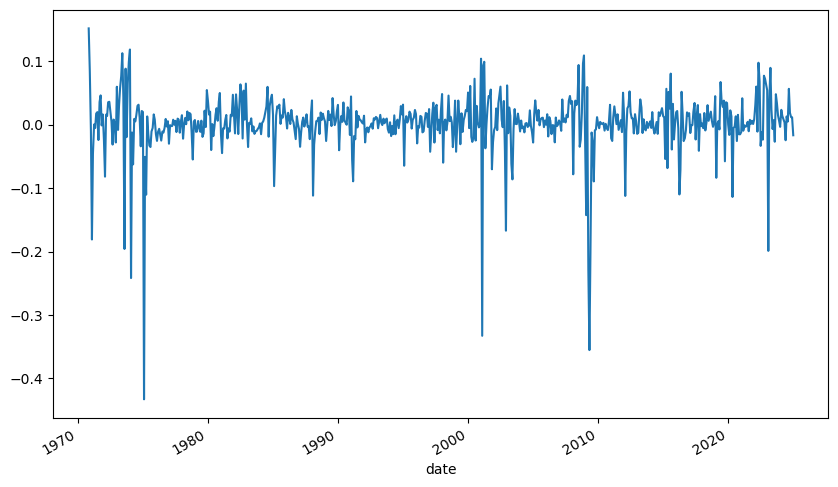

In [34]:
gamma_mom.ret11_1.plot()

In [35]:
# Fama-Macbeth regressions results
fm_summary(gamma_mom)

,mean,std_error,tstat
Intercept,0.004565,0.003237,1.410139
ret11_1,0.002150,0.001804,1.191927


### Does ret1 forcast future returns?

In [36]:
gamma_rev = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret1',include_groups=False))
gamma_rev.head()

,Intercept,ret1
date,,
1970-10-30,-0.033043,-0.258334
1970-11-30,0.006658,0.114236
1970-12-31,0.078616,-0.030629
1971-01-29,0.152078,-0.231513
1971-02-26,0.043502,0.002026


In [37]:
# Fama-Macbeth regressions results
fm_summary(gamma_rev) 

,mean,std_error,tstat
Intercept,0.007381,0.002262,3.262617
ret1,-0.039929,0.004040,-9.883346


### Does ret11 forcast future returns?

In [38]:
gamma_mom2 = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret11_2',include_groups=False))
gamma_mom2.head()

,Intercept,ret11_2
date,,
1970-10-30,-0.207653,0.192657
1970-11-30,-0.074125,0.090033
1970-12-31,0.084399,-0.007466
1971-01-29,0.268664,-0.174306
1971-02-26,0.088120,-0.050674


In [39]:
# Fama-Macbeth regressions results
fm_summary(gamma_mom2)

,mean,std_error,tstat
Intercept,0.001364,0.003084,0.442359
ret11_2,0.005610,0.001627,3.448070


### Do ret11_1 and ret1 forcast future returns?

In [40]:
# Fama-Macbeth regressions results
gamma = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret11_1 + ret1',include_groups=False))
fm_summary(gamma)

,mean,std_error,tstat
Intercept,0.000047,0.003026,0.015445
ret11_1,0.006640,0.001616,4.107762
ret1,-0.047278,0.003490,-13.548432


### Do ret11_2 and ret1 forcast future returns?

In [41]:
# Fama-Macbeth regressions results
gamma = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret11_2 + ret1',include_groups=False))
fm_summary(gamma)

,mean,std_error,tstat
Intercept,0.001086,0.002974,0.365242
ret11_2,0.005616,0.001557,3.606318
ret1,-0.041048,0.003808,-10.778789


## Long-short portfolio

### Sort Portfolio

In [42]:
mdata['mesum'] = mdata.groupby(['date', 'permco']).me.transform("sum", min_count=1)

In [43]:
mdata = mdata[mdata.mesum.notnull()]

In [44]:
mdata.reset_index(inplace=True)

In [45]:
port = sort_portfolios(data = mdata,
                       quantiles={'mesum': [0.5],
                                  'ret11_2': [0.3, 0.7],
                                  'ret11_1': [0.3, 0.7],
                                  'ret1': [0.3, 0.7]},
                       id_variables=['date', 'permno', 'exchcd'],
                       exch_cd=[1])

NYSE breakpoints were calculated for mesum.
Stocks were sorted according to breakpoints, starting in 1970-10-30 00:00:00
NYSE breakpoints were calculated for ret11_2.
Stocks were sorted according to breakpoints, starting in 1970-10-30 00:00:00
NYSE breakpoints were calculated for ret11_1.
Stocks were sorted according to breakpoints, starting in 1970-10-30 00:00:00
NYSE breakpoints were calculated for ret1.
Stocks were sorted according to breakpoints, starting in 1970-10-30 00:00:00


Look at the data.

In [46]:
port[port.permno==10006].head()

,date,permno,ret1portfolio,ret11_1portfolio,ret11_2portfolio,mesumportfolio
0,1970-10-30,10006.0,ret12,ret11_12,ret11_22,mesum2
2152,1970-11-30,10006.0,ret12,ret11_12,ret11_22,mesum2
4320,1970-12-31,10006.0,ret13,ret11_12,ret11_22,mesum2
6499,1971-01-29,10006.0,ret11,ret11_12,ret11_22,mesum2
8687,1971-02-26,10006.0,ret12,ret11_12,ret11_22,mesum2


### Portfolio returns

#### Merge data

In [47]:
fdata = pd.merge(mdata[['permno', 'date', 'exret', 'melag_weights']], 
                port,
                on = ['permno', 'date']) 

Have a look at Apple in 2019. Which portfolio did Apple belong to?

In [48]:
fdata[(fdata.permno==14593) & (fdata.date.dt.year>=2019)].tail(10)

,permno,date,exret,melag_weights,ret1portfolio,ret11_1portfolio,ret11_2portfolio,mesumportfolio
334415,14593,2024-03-28,-0.055443,2.791120e+06,ret11,ret11_12,ret11_23,mesum2
334416,14593,2024-04-30,-0.011570,2.630106e+06,ret11,ret11_12,ret11_22,mesum2
334417,14593,2024-05-31,0.125744,2.611854e+06,ret13,ret11_11,ret11_22,mesum2
334418,14593,2024-06-28,0.091428,2.947977e+06,ret13,ret11_12,ret11_21,mesum2
334419,14593,2024-07-31,0.049700,3.206112e+06,ret13,ret11_12,ret11_22,mesum2
334420,14593,2024-08-30,0.027867,3.376535e+06,ret12,ret11_12,ret11_22,mesum2
334421,14593,2024-09-30,0.012848,3.481747e+06,ret12,ret11_12,ret11_22,mesum2
334422,14593,2024-10-31,-0.034336,3.522211e+06,ret12,ret11_12,ret11_22,mesum2
334423,14593,2024-11-29,0.047703,3.414816e+06,ret12,ret11_12,ret11_22,mesum2
334424,14593,2024-12-31,0.051492,3.587438e+06,ret12,ret11_12,ret11_22,mesum2


#### Calculate returns

In [49]:
# Reversal Returns 
rev = fdata.groupby(['date', 
                     'mesumportfolio', 
                     'ret1portfolio'], observed=False).apply(lambda x: np.average(x['exret'], 
                                                                   weights = x['melag_weights']),include_groups=False)
display(rev)

date        mesumportfolio  ret1portfolio
1970-10-30  mesum1          ret11           -0.025202
                            ret12           -0.055249
                            ret13           -0.101283
            mesum2          ret11           -0.009772
                            ret12           -0.018604
                                               ...   
2024-12-31  mesum1          ret12           -0.086676
                            ret13           -0.078993
            mesum2          ret11           -0.014628
                            ret12           -0.039251
                            ret13           -0.028401
Length: 3906, dtype: float64

In [50]:
rev = rev.unstack(level=[1, 2])
display(rev)

mesumportfolio    mesum1                        mesum2                    
ret1portfolio      ret11     ret12     ret13     ret11     ret12     ret13
date                                                                      
1970-10-30     -0.025202 -0.055249 -0.101283 -0.009772 -0.018604 -0.061833
1970-11-30     -0.007556  0.007791  0.013077  0.057785  0.055633  0.043627
1970-12-31      0.089769  0.073310  0.065054  0.077108  0.059134  0.045373
1971-01-29      0.133908  0.109467  0.076747  0.043691  0.037085  0.059520
1971-02-26      0.049126  0.032587  0.023697  0.017585  0.004421  0.011798
...                  ...       ...       ...       ...       ...       ...
2024-08-30     -0.052977 -0.029565 -0.030438  0.015581  0.028231  0.000734
2024-09-30     -0.010371 -0.007312 -0.003247  0.032349  0.021066  0.007450
2024-10-31     -0.027666 -0.018400 -0.005824 -0.022283 -0.005265 -0.010442
2024-11-29      0.069778  0.103238  0.115349  0.022879  0.071431  0.078389
2024-12-31     -0.082821 -0.086676 -0.078993 -0.014628 -0.039251 -0.028401

[651 rows x 6 columns]

In [51]:
rev_ret = rev.loc[:, idx[:, 'ret13']].mean(axis=1)-rev.loc[:, idx[:, 'ret11']].mean(axis=1)
rev_ret = rev_ret.to_frame('rev')

In [52]:
# Reversal not value-weighting
rev2 = fdata.groupby(['date', 
                      'mesumportfolio', 
                      'ret1portfolio'], observed=False).apply(lambda x: np.average(x['exret']),include_groups=False)
rev2 = rev2.unstack(level=[1, 2])
rev2_ret = rev2.loc[:, idx[:, 'ret13']].mean(axis=1)-rev2.loc[:, idx[:, 'ret11']].mean(axis=1)
rev2_ret = rev2_ret.to_frame('rev2')

In [53]:
# Momentum not skipping 1-month
mom2 = fdata.groupby(['date', 
                      'mesumportfolio', 
                      'ret11_1portfolio'], observed=False).apply(lambda x: np.average(x['exret'], 
                                                                weights = x['melag_weights']),include_groups=False)
mom2 = mom2.unstack(level=[1, 2])
mom2_ret = mom2.loc[:, idx[:, 'ret11_13']].mean(axis=1)-mom2.loc[:, idx[:, 'ret11_11']].mean(axis=1)
mom2_ret = mom2_ret.to_frame('mom2')

In [54]:
# Momemtum Returns
mom = fdata.groupby(['date', 
                     'mesumportfolio', 
                     'ret11_2portfolio'], observed=False).apply(lambda x: np.average(x['exret'], 
                                                                weights = x['melag_weights']),include_groups=False)
mom = mom.unstack(level=[1, 2])
mom_ret = mom.loc[:, idx[:, 'ret11_23']].mean(axis=1)-mom.loc[:, idx[:, 'ret11_21']].mean(axis=1)
mom_ret = mom_ret.to_frame('mom')

In [55]:
ret = mom_ret.join(rev_ret).join(mom2_ret).join(rev2_ret)

#### Long-short portfolio returns

<Axes: xlabel='date'>

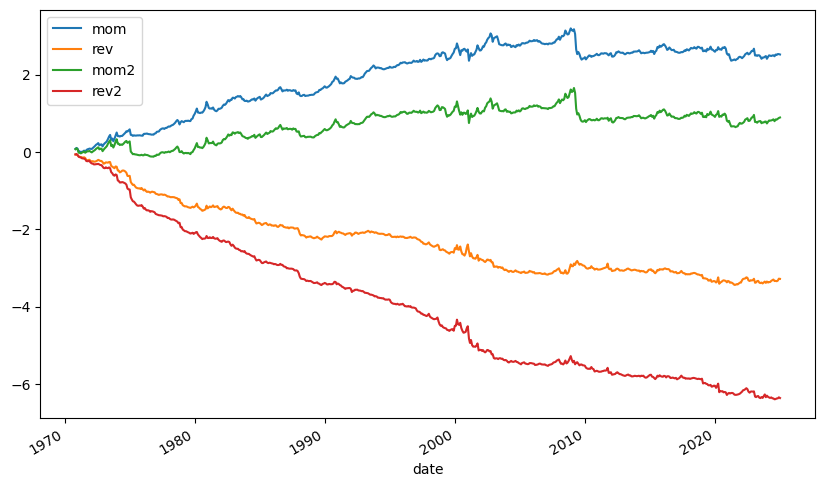

In [56]:
np.log(1+ret).cumsum().plot()

### Compare Sharpe-ratio

In [57]:
(ret.mean()/ret.std())*np.sqrt(12)

mom     0.395002
rev    -0.477859
mom2    0.187764
rev2   -0.932839
dtype: float64

## Are there alphas?

In [58]:
# FF five factor
ff = kf_factors(ff_factor_file='F-F_Research_Data_5_Factors_2x3', freq='monthly')
ff.drop(columns=['date'], inplace=True)
ff_ret = ff.set_index('mdate')/100
ff_ret.rename(columns = {'Mkt-RF': 'MktRF'}, inplace=True)

/Users/kh3112/Dropbox/Columbia PhD/2024-2025 (Spring)/Big Data in Finance/big_data2025/lecture_notes/../../fire_pytools/import_kf/kf_factors.py:82: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = web.DataReader(ff_factor_file, 'famafrench', start='1925-01-01')
/Users/kh3112/Dropbox/Columbia PhD/2024-2025 (Spring)/Big Data in Finance/big_data2025/lecture_notes/../../fire_pytools/import_kf/kf_factors.py:82: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = web.DataReader(ff_factor_file, 'famafrench', start='1925-01-01')


In [59]:
ff

,Mkt-RF,SMB,HML,RMW,CMA,RF,mdate
0,-0.39,-0.41,-0.97,0.68,-1.18,0.27,196307
1,5.07,-0.80,1.80,0.36,-0.35,0.25,196308
2,-1.57,-0.52,0.13,-0.71,0.29,0.27,196309
3,2.53,-1.39,-0.10,2.80,-2.01,0.29,196310
4,-0.85,-0.88,1.75,-0.51,2.24,0.27,196311
...,...,...,...,...,...,...,...
733,1.61,-3.65,-1.13,0.85,0.86,0.48,202408
734,1.74,-1.02,-2.59,0.04,-0.26,0.40,202409
735,-0.97,-0.88,0.89,-1.38,1.03,0.39,202410
736,6.51,4.78,-0.05,-2.62,-2.17,0.40,202411


In [60]:
ret.reset_index(inplace=True) 
ret['mdate'] = ret.date.dt.year * 100 +  ret.date.dt.month 

In [61]:
ret.set_index('mdate', inplace=True)

In [62]:
# Merge 
ret = ret.join(ff_ret)
ret.reset_index(inplace=True)
ret.set_index('date', inplace=True)

In [63]:
ret.head()

,mdate,mom,rev,mom2,rev2,MktRF,SMB,HML,RMW,CMA,RF
date,,,,,,,,,,,
1970-10-30,197010,0.083603,-0.064071,0.073112,-0.062213,-0.0228,-0.0443,0.0022,0.0171,0.0234,0.0046
1970-11-30,197011,0.023131,0.003238,0.023705,0.009349,0.0460,-0.0386,0.0169,0.0157,0.0147,0.0046
1970-12-31,197012,-0.022009,-0.028225,-0.034313,-0.024298,0.0572,0.0294,0.0100,0.0027,0.0030,0.0042
1971-01-29,197101,-0.070859,-0.020666,-0.076117,-0.045204,0.0484,0.0754,0.0133,-0.0199,0.0007,0.0038
1971-02-26,197102,0.003639,-0.015608,-0.002177,-0.008825,0.0141,0.0204,-0.0123,0.0062,-0.0070,0.0033


In [64]:
smf.ols('mom ~ MktRF', data=ret.loc['2010-01-01':]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mom   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     21.72
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           6.16e-06
Time:                        23:32:56   Log-Likelihood:                 355.82
No. Observations:                 180   AIC:                            -707.6
Df Residuals:                     178   BIC:                            -701.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0039      0.003      1.521      0.130      -0.001       0.009
MktRF         -0.2686      0.058     -4.660      0.000      -0.382      -0.155
==============================================================================
Omnibus:                       23.627   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.096
Skew:                          -0.683   Prob(JB):                     1.96e-09
Kurtosis:                       4.866   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
smf.ols('mom ~ MktRF', data=ret).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mom   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     27.47
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           2.16e-07
Time:                        23:32:56   Log-Likelihood:                 1151.2
No. Observations:                 651   AIC:                            -2298.
Df Residuals:                     649   BIC:                            -2289.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0060      0.002      3.663      0.000       0.003       0.009
MktRF         -0.1863      0.036     -5.241      0.000      -0.256      -0.116
==============================================================================
Omnibus:                      230.656   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1990.863
Skew:                          -1.329   Prob(JB):                         0.00
Kurtosis:                      11.145   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
smf.ols('mom ~ MktRF + SMB + HML', data=ret).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mom   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     23.34
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           2.34e-14
Time:                        23:32:56   Log-Likelihood:                 1171.1
No. Observations:                 651   AIC:                            -2334.
Df Residuals:                     647   BIC:                            -2316.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0071      0.002      4.462      0.000       0.004       0.010
MktRF         -0.2179      0.037     -5.952      0.000      -0.290      -0.146
SMB           -0.0738      0.054     -1.372      0.171      -0.180       0.032
HML           -0.3195      0.052     -6.120      0.000      -0.422      -0.217
==============================================================================
Omnibus:                      227.526   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1919.749
Skew:                          -1.314   Prob(JB):                         0.00
Kurtosis:                      10.992   Cond. No.                         36.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
smf.ols('mom ~ MktRF + SMB + HML + RMW + CMA', data=ret).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mom   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     18.59
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           2.82e-17
Time:                        23:32:56   Log-Likelihood:                 1181.5
No. Observations:                 651   AIC:                            -2351.
Df Residuals:                     645   BIC:                            -2324.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0055      0.002      3.377      0.001       0.002       0.009
MktRF         -0.1635      0.038     -4.298      0.000      -0.238      -0.089
SMB           -0.0271      0.057     -0.477      0.633      -0.139       0.085
HML           -0.5261      0.070     -7.521      0.000      -0.663      -0.389
RMW            0.1814      0.075      2.415      0.016       0.034       0.329
CMA            0.4545      0.110      4.133      0.000       0.239       0.670
==============================================================================
Omnibus:                      215.636   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1738.401
Skew:                          -1.244   Prob(JB):                         0.00
Kurtosis:                      10.609   Cond. No.                         79.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Should we add Reversal to our portfolio?

In [68]:
smf.ols('rev ~ MktRF + SMB + HML + RMW + CMA + mom', data=ret).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rev   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     24.02
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           1.02e-25
Time:                        23:32:56   Log-Likelihood:                 1371.8
No. Observations:                 651   AIC:                            -2730.
Df Residuals:                     644   BIC:                            -2698.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0045      0.001     -3.646      0.000      -0.007      -0.002
MktRF         -0.1578      0.029     -5.474      0.000      -0.214      -0.101
SMB           -0.1106      0.042     -2.604      0.009      -0.194      -0.027
HML           -0.0988      0.055     -1.812      0.070      -0.206       0.008
RMW            0.0027      0.056      0.047      0.962      -0.108       0.113
CMA            0.1857      0.083      2.231      0.026       0.022       0.349
mom            0.1828      0.029      6.215      0.000       0.125       0.241
==============================================================================
Omnibus:                       88.078   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              883.390
Skew:                          -0.072   Prob(JB):                    1.49e-192
Kurtosis:                       8.705   Cond. No.                         81.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
ret.drop(columns='mdate', inplace = True)

<Axes: xlabel='date'>

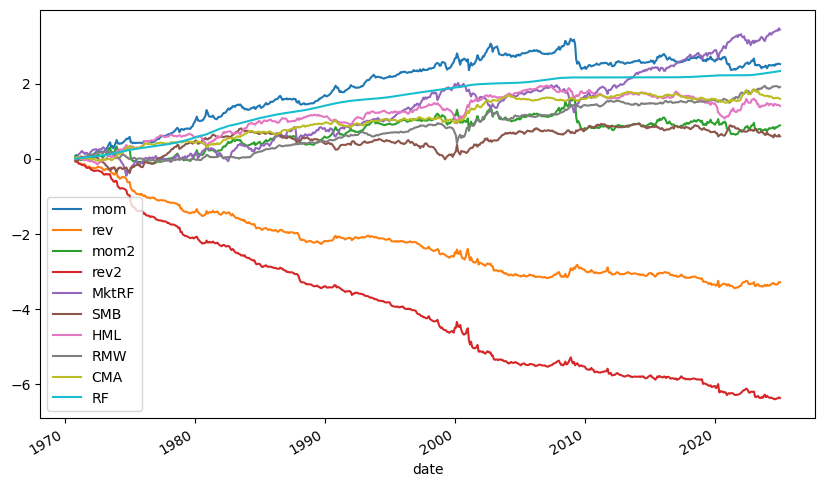

In [70]:
np.log(1+ret).cumsum().plot()

## Optimal Portfolio

In [71]:
print('Market portfolio returns: \n', ret['MktRF'], end='\n\n')
print('Market portfolio SR: ', 
      np.sqrt(12) * ret['MktRF'].mean()/ret['MktRF'].std(), end='\n\n')

Market portfolio returns: 
 date
1970-10-30   -0.0228
1970-11-30    0.0460
1970-12-31    0.0572
1971-01-29    0.0484
1971-02-26    0.0141
               ...  
2024-08-30    0.0161
2024-09-30    0.0174
2024-10-31   -0.0097
2024-11-29    0.0651
2024-12-31   -0.0317
Name: MktRF, Length: 651, dtype: float64

Market portfolio SR:  0.4820652878475234



In [72]:
Sigma = ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA']].cov()
mu = ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA']].mean()

w_mve = np.dot(np.linalg.inv(Sigma), mu)
print('Optimal portfolio weights: \n', w_mve, end='\n\n')
r_mve = (ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA']]* w_mve).sum(axis=1)
print('Optimal portfolio returns: \n', r_mve, end='\n\n')
print('Optimal portfolio SR: ', 
      np.sqrt(12) * r_mve.mean()/r_mve.std(), end='\n\n')

Optimal portfolio weights: 
 [ 5.26533932  2.5125464  -2.20158413  9.39546995 12.43998166]

Optimal portfolio returns: 
 date
1970-10-30    0.215559
1970-11-30    0.438391
1970-12-31    0.415718
1971-01-29    0.236745
1971-02-26    0.123749
                ...   
2024-08-30    0.204787
2024-09-30    0.094424
2024-10-31   -0.094304
2024-11-29   -0.052135
2024-12-31   -0.165042
Length: 651, dtype: float64

Optimal portfolio SR:  1.0640216782656



In [73]:
Sigma_mom = ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']].cov()
mu_mom = ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']].mean()

w_mve_mom = np.dot(np.linalg.inv(Sigma_mom), mu_mom)
print('Optimal portfolio weights: \n', w_mve_mom, end='\n\n')
r_mve_mom = (ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']]* w_mve_mom).sum(axis=1)
print('Optimal portfolio returns: \n', r_mve_mom, end='\n\n')
print('Optimal portfolio SR: ', 
      np.sqrt(12) * r_mve_mom.mean()/r_mve_mom.std(), end='\n\n')

Optimal portfolio weights: 
 [ 5.84171162  2.60818207 -0.34718679  8.75601943 10.83810902  3.52480611]

Optimal portfolio returns: 
 date
1970-10-30    0.448527
1970-11-30    0.540497
1970-12-31    0.385934
1971-01-29    0.058357
1971-02-26    0.131094
                ...   
2024-08-30    0.325328
2024-09-30    0.031314
2024-10-31   -0.012976
2024-11-29    0.030831
2024-12-31   -0.266622
Length: 651, dtype: float64

Optimal portfolio SR:  1.1679121218038633

